# Understanding RAG (Retrieval-Augmented Generation)

## Learning Objectives
By the end of this notebook, you will understand:
1. What RAG is and why it's important
2. The components of a RAG system
3. How retrieval and generation work together
4. Common challenges and solutions

## What is RAG?

RAG stands for **Retrieval-Augmented Generation**. It's a technique that combines:
- **Retrieval**: Finding relevant information from a knowledge base
- **Augmented**: Enhancing the LLM's input with retrieved information
- **Generation**: Using an LLM to generate responses based on the augmented input

### Why do we need RAG?

1. **Knowledge Cutoff**: LLMs have training data cutoffs and don't know recent information
2. **Hallucination**: LLMs can make up facts that sound plausible
3. **Domain Specificity**: General LLMs may not be experts in specific domains
4. **Cost Efficiency**: Retrieving relevant context reduces the need for larger models

## RAG Architecture Components

```
Query → Retriever → Retrieved Docs → Generator → Response
                    ↑                        ↑
                Knowledge Base            LLM
```

### 1. Knowledge Base
- **Documents**: Raw text data (Wikipedia, PDFs, etc.)
- **Chunks**: Split documents into manageable pieces
- **Embeddings**: Vector representations of chunks
- **Vector Store**: Database for similarity search

### 2. Retriever
- **Embedding Model**: Converts text to vectors
- **Similarity Search**: Finds relevant chunks
- **Ranking**: Orders results by relevance

### 3. Generator
- **LLM**: Large Language Model (Llama, GPT, etc.)
- **Prompt Engineering**: How we format input to the LLM
- **Context Management**: How we handle retrieved information

## Let's Build Our Understanding Step by Step


In [8]:
# First, let's import the libraries we'll need
import numpy as np
import pandas as pd
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to learn about RAG systems!")


Libraries imported successfully!
Ready to learn about RAG systems!


## Step 1: Understanding Text Embeddings

Let's start by understanding how text becomes numbers that computers can work with. This is the foundation of everything we'll do.

### What are Embeddings?

Embeddings are numerical representations of text that capture semantic meaning. Words or sentences that are similar in meaning have similar embedding vectors.

Think of it like this: if you had to describe a word using just 5 numbers, how would you do it? Embeddings do this with hundreds or thousands of dimensions.

In [10]:
# Let's create a simple example to understand embeddings
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# We'll use a lightweight embedding model for demonstration
print("Loading embedding model...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, fast model for learning

# Let's create some example sentences
sentences = [
    "The cat sat on the mat",
    "A feline rested on the rug", 
    "Dogs are loyal pets",
    "Cats and dogs are different animals",
    "The weather is nice today",
    "It's sunny outside"
]

print("Creating embeddings for our example sentences...")
embeddings = model.encode(sentences)

print(f"Created embeddings with shape: {embeddings.shape}")
print(f"Each sentence is now represented by {embeddings.shape[1]} numbers")

# Let's see what these numbers look like
print(f"\nFirst sentence embedding (first 10 values): {embeddings[0][:10]}")
print(f"Second sentence embedding (first 10 values): {embeddings[1][:10]}")

# Calculate similarities
similarities = cosine_similarity(embeddings)

print("\nSimilarity matrix (higher = more similar):")
for i, sentence in enumerate(sentences):
    print(f"{i}: {sentence}")

print("\nSimilarity scores:")
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        sim = similarities[i][j]
        print(f"'{sentences[i][:20]}...' vs '{sentences[j][:20]}...': {sim:.3f}")


Loading embedding model...
Creating embeddings for our example sentences...
Created embeddings with shape: (6, 384)
Each sentence is now represented by 384 numbers

First sentence embedding (first 10 values): [ 0.13040185 -0.01187016 -0.02811701  0.05123867 -0.05597443  0.03019156
  0.03016133  0.02469836 -0.01837048  0.05876683]
Second sentence embedding (first 10 values): [0.07218208 0.04459076 0.05393586 0.12767875 0.00213373 0.0587419
 0.02538777 0.00386503 0.0101001  0.0319241 ]

Similarity matrix (higher = more similar):
0: The cat sat on the mat
1: A feline rested on the rug
2: Dogs are loyal pets
3: Cats and dogs are different animals
4: The weather is nice today
5: It's sunny outside

Similarity scores:
'The cat sat on the m...' vs 'A feline rested on t...': 0.564
'The cat sat on the m...' vs 'Dogs are loyal pets...': 0.215
'The cat sat on the m...' vs 'Cats and dogs are di...': 0.319
'The cat sat on the m...' vs 'The weather is nice ...': 0.013
'The cat sat on the m...' vs 'I

## Step 2: Visualizing Embeddings

Let's visualize these embeddings to see how similar sentences cluster together. This will help you understand how the system "sees" text relationships.


Reducing dimensions for visualization...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


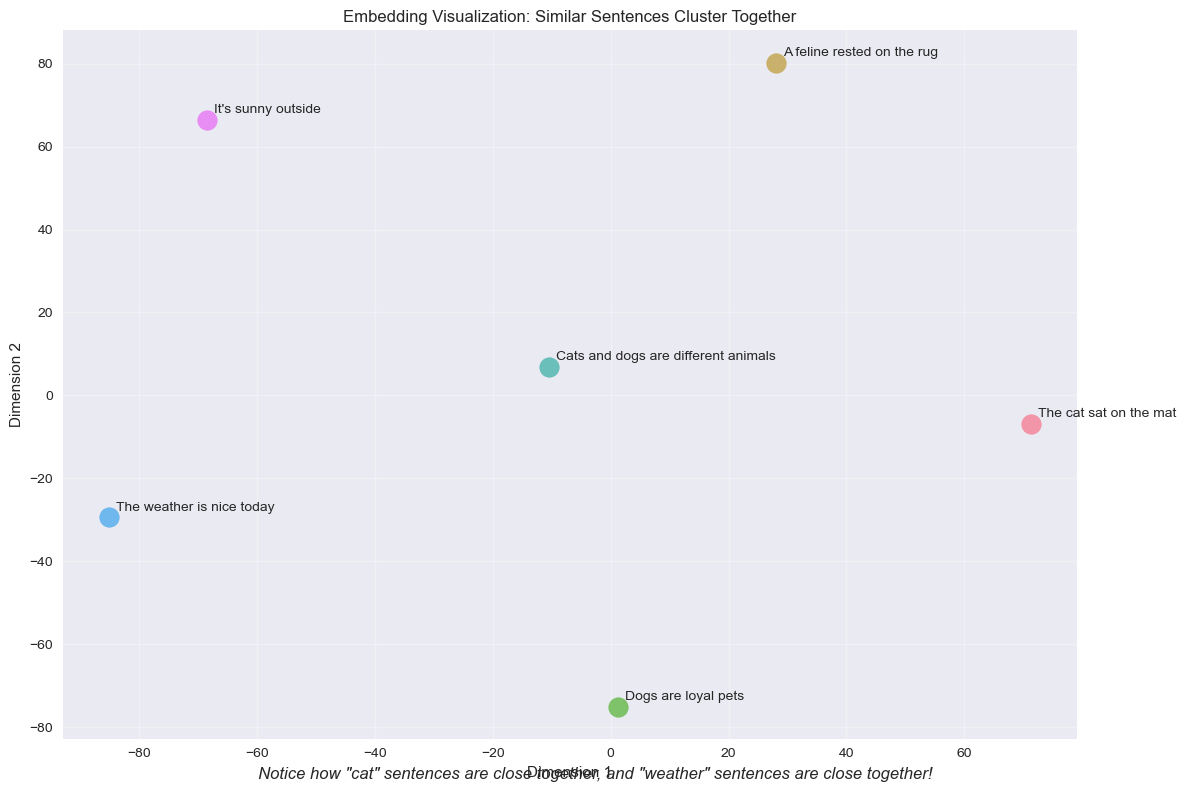

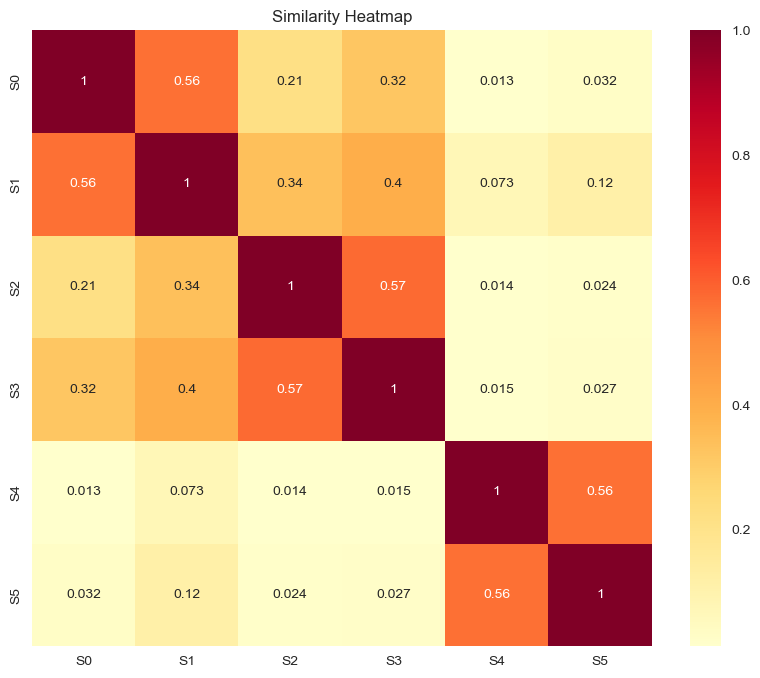


Key Insights:
1. Sentences about cats are more similar to each other than to weather sentences
2. The embedding model understands semantic similarity, not just word overlap
3. This is how RAG systems find relevant documents - by similarity in embedding space!


In [11]:
# Visualize embeddings using dimensionality reduction
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions from 384 to 2 for visualization
print("Reducing dimensions for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(sentences)-1))
embeddings_2d = tsne.fit_transform(embeddings)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each sentence as a point
for i, sentence in enumerate(sentences):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], s=200, alpha=0.7)
    plt.annotate(sentence, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.title('Embedding Visualization: Similar Sentences Cluster Together')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)

# Add some insight
plt.figtext(0.5, 0.02, 
           'Notice how "cat" sentences are close together, and "weather" sentences are close together!', 
           ha='center', fontsize=12, style='italic')

plt.tight_layout()
plt.show()

# Let's also create a heatmap of similarities
plt.figure(figsize=(10, 8))
sns.heatmap(similarities, annot=True, cmap='YlOrRd', 
           xticklabels=[f"S{i}" for i in range(len(sentences))],
           yticklabels=[f"S{i}" for i in range(len(sentences))])
plt.title('Similarity Heatmap')
plt.show()

print("\nKey Insights:")
print("1. Sentences about cats are more similar to each other than to weather sentences")
print("2. The embedding model understands semantic similarity, not just word overlap")
print("3. This is how RAG systems find relevant documents - by similarity in embedding space!")


## Step 3: Building a Simple Retrieval System

Now let's build a mini retrieval system to see how this works in practice. We'll create a small "knowledge base" and see how we can find relevant information.


In [12]:
# Let's create a simple knowledge base
knowledge_base = [
    "Cats are small, typically furry, carnivorous mammals. They are often kept as house pets.",
    "Dogs are domesticated mammals that have been selectively bred over thousands of years.",
    "The weather forecast predicts rain for tomorrow with temperatures around 15 degrees Celsius.",
    "Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data.",
    "Python is a high-level programming language known for its simplicity and readability.",
    "The solar system consists of eight planets orbiting around the sun.",
    "Cats communicate through various vocalizations including meowing, purring, and hissing.",
    "Dogs are known for their loyalty and are often called 'man's best friend'.",
    "Deep learning uses neural networks with multiple layers to process complex data patterns.",
    "Jupiter is the largest planet in our solar system and has a Great Red Spot."
]

print("Our Knowledge Base:")
for i, fact in enumerate(knowledge_base):
    print(f"{i+1}. {fact}")

# Create embeddings for our knowledge base
print("\nCreating embeddings for knowledge base...")
kb_embeddings = model.encode(knowledge_base)

print(f"Knowledge base embeddings shape: {kb_embeddings.shape}")

# Function to find most relevant documents
def find_relevant_docs(query, knowledge_base, kb_embeddings, model, top_k=3):
    """
    Find the most relevant documents for a given query.
    """
    # Encode the query
    query_embedding = model.encode([query])
    
    # Calculate similarities
    similarities = cosine_similarity(query_embedding, kb_embeddings)[0]
    
    # Get top-k most similar documents
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    results = []
    for i, idx in enumerate(top_indices):
        results.append({
            'rank': i + 1,
            'similarity': similarities[idx],
            'document': knowledge_base[idx]
        })
    
    return results

# Test our retrieval system
test_queries = [
    "Tell me about cats",
    "What is machine learning?",
    "Information about planets",
    "Dog behavior and characteristics"
]

print("\n" + "="*60)
print("TESTING OUR RETRIEVAL SYSTEM")
print("="*60)

for query in test_queries:
    print(f"\nQuery: '{query}'")
    print("-" * 40)
    
    results = find_relevant_docs(query, knowledge_base, kb_embeddings, model)
    
    for result in results:
        print(f"Rank {result['rank']} (Similarity: {result['similarity']:.3f}): {result['document']}")
    
    print()


Our Knowledge Base:
1. Cats are small, typically furry, carnivorous mammals. They are often kept as house pets.
2. Dogs are domesticated mammals that have been selectively bred over thousands of years.
3. The weather forecast predicts rain for tomorrow with temperatures around 15 degrees Celsius.
4. Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data.
5. Python is a high-level programming language known for its simplicity and readability.
6. The solar system consists of eight planets orbiting around the sun.
7. Cats communicate through various vocalizations including meowing, purring, and hissing.
8. Dogs are known for their loyalty and are often called 'man's best friend'.
9. Deep learning uses neural networks with multiple layers to process complex data patterns.
10. Jupiter is the largest planet in our solar system and has a Great Red Spot.

Creating embeddings for knowledge base...
Knowledge base embeddings shape: (10, 384)

T

## Step 4: Interactive Query Testing

Let's make this interactive! You can test your own queries and see how well our simple retrieval system works.


In [13]:
# Interactive query testing
def interactive_search():
    """
    Interactive function to test queries against our knowledge base.
    """
    print("🔍 Interactive Knowledge Base Search")
    print("="*50)
    print("Enter your questions about cats, dogs, weather, programming, or planets!")
    print("Type 'quit' to exit.")
    print()
    
    while True:
        try:
            query = input("Enter your question: ").strip()
            
            if query.lower() in ['quit', 'exit', 'q']:
                print("Goodbye!")
                break
            
            if not query:
                print("Please enter a question.")
                continue
            
            print(f"\nSearching for: '{query}'")
            print("-" * 40)
            
            results = find_relevant_docs(query, knowledge_base, kb_embeddings, model)
            
            if results:
                for result in results:
                    print(f"📄 Rank {result['rank']} (Similarity: {result['similarity']:.3f})")
                    print(f"   {result['document']}")
                    print()
            else:
                print("No results found.")
            
            print("-" * 40)
            
        except KeyboardInterrupt:
            print("\nGoodbye!")
            break
        except Exception as e:
            print(f"Error: {e}")

# Uncomment the line below to run interactive search
# interactive_search()

# For notebook demonstration, let's show a few more examples
demo_queries = [
    "How do cats communicate?",
    "What programming language is simple?",
    "Which planet is the largest?",
    "Tell me about artificial intelligence"
]

print("Demo: Testing more queries")
print("="*30)

for query in demo_queries:
    print(f"\nQuery: '{query}'")
    results = find_relevant_docs(query, knowledge_base, kb_embeddings, model)
    
    for result in results[:2]:  # Show top 2 results
        print(f"  • {result['document']} (Score: {result['similarity']:.3f})")
    
    print()

print("Try running 'interactive_search()' to test your own queries!")


Demo: Testing more queries

Query: 'How do cats communicate?'
  • Cats communicate through various vocalizations including meowing, purring, and hissing. (Score: 0.784)
  • Cats are small, typically furry, carnivorous mammals. They are often kept as house pets. (Score: 0.445)


Query: 'What programming language is simple?'
  • Python is a high-level programming language known for its simplicity and readability. (Score: 0.637)
  • Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data. (Score: 0.193)


Query: 'Which planet is the largest?'
  • Jupiter is the largest planet in our solar system and has a Great Red Spot. (Score: 0.644)
  • The solar system consists of eight planets orbiting around the sun. (Score: 0.485)


Query: 'Tell me about artificial intelligence'
  • Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data. (Score: 0.580)
  • Deep learning uses neural networks with

## Step 5: Understanding RAG Challenges

Now that we've built a simple retrieval system, let's explore some of the challenges and limitations we'll face when building a real RAG system.


In [14]:
# Let's explore some RAG challenges with examples

print("🔍 RAG System Challenges and Solutions")
print("="*50)

# Challenge 1: Ambiguous queries
print("\n1. AMBIGUOUS QUERIES")
print("-" * 20)

ambiguous_queries = [
    "What is Python?",  # Could be programming language or snake
    "Tell me about Apple",  # Could be fruit or company
    "What is the capital?"  # Capital of what?
]

for query in ambiguous_queries:
    print(f"\nQuery: '{query}'")
    results = find_relevant_docs(query, knowledge_base, kb_embeddings, model, top_k=2)
    for result in results:
        print(f"  • {result['document']} (Score: {result['similarity']:.3f})")

print("\n💡 Challenge: Without context, the system might retrieve irrelevant information")
print("💡 Solution: Better query understanding, context from conversation history")

# Challenge 2: Chunking problems
print("\n\n2. CHUNKING CHALLENGES")
print("-" * 25)

# Let's create a longer document and see how chunking affects retrieval
long_document = """
Cats are fascinating animals with a rich history of domestication. 
They were first domesticated in ancient Egypt around 4,000 years ago.
Cats are obligate carnivores, meaning they must eat meat to survive.
They have excellent night vision and can see in light levels six times lower than humans.
Cats communicate through various methods including vocalizations, body language, and scent marking.
The domestic cat is a member of the Felidae family, which includes lions, tigers, and other wild cats.
Cats are known for their independent nature, but they can form strong bonds with their human companions.
They spend a significant portion of their day sleeping, typically 12-16 hours.
Cats have retractable claws that help them climb and hunt effectively.
The average lifespan of a domestic cat is 13-17 years, though some live much longer.
"""

# Split into chunks (simulating chunking)
chunks = [
    "Cats are fascinating animals with a rich history of domestication. They were first domesticated in ancient Egypt around 4,000 years ago.",
    "Cats are obligate carnivores, meaning they must eat meat to survive. They have excellent night vision and can see in light levels six times lower than humans.",
    "Cats communicate through various methods including vocalizations, body language, and scent marking. The domestic cat is a member of the Felidae family, which includes lions, tigers, and other wild cats.",
    "Cats are known for their independent nature, but they can form strong bonds with their human companions. They spend a significant portion of their day sleeping, typically 12-16 hours.",
    "Cats have retractable claws that help them climb and hunt effectively. The average lifespan of a domestic cat is 13-17 years, though some live much longer."
]

print("Original document split into chunks:")
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: {chunk[:60]}...")

# Test retrieval with chunked content
chunk_embeddings = model.encode(chunks)
test_query = "How long do cats sleep?"

print(f"\nQuery: '{test_query}'")
results = find_relevant_docs(test_query, chunks, chunk_embeddings, model, top_k=2)

for result in results:
    print(f"  • {result['document']} (Score: {result['similarity']:.3f})")

print("\n💡 Challenge: Information might be split across chunks")
print("💡 Solution: Overlapping chunks, better chunking strategies, re-ranking")

# Challenge 3: Similarity threshold
print("\n\n3. SIMILARITY THRESHOLDS")
print("-" * 25)

test_queries = [
    "What is machine learning?",
    "Tell me about neural networks",
    "How does artificial intelligence work?",
    "What is the weather like?"  # This should have low similarity to our knowledge base
]

for query in test_queries:
    results = find_relevant_docs(query, knowledge_base, kb_embeddings, model, top_k=1)
    best_match = results[0]
    
    relevance = "✅ Relevant" if best_match['similarity'] > 0.3 else "❌ Not Relevant"
    print(f"'{query}' -> Best match: {best_match['similarity']:.3f} {relevance}")

print("\n💡 Challenge: Setting appropriate similarity thresholds")
print("💡 Solution: Experiment with thresholds, use multiple retrieval strategies")

# Challenge 4: Hallucination prevention
print("\n\n4. HALLUCINATION PREVENTION")
print("-" * 30)

# Simulate what might happen if we don't have relevant information
irrelevant_query = "What is the population of Mars?"
results = find_relevant_docs(irrelevant_query, knowledge_base, kb_embeddings, model, top_k=3)

print(f"Query: '{irrelevant_query}'")
print("Retrieved documents:")
for result in results:
    print(f"  • {result['document']} (Score: {result['similarity']:.3f})")

print("\n💡 Challenge: LLM might generate answers even when no relevant info exists")
print("💡 Solution: Check retrieval quality, use confidence thresholds, provide 'no relevant info' responses")

print("\n" + "="*60)
print("These challenges show why RAG systems need careful design!")
print("In the next notebooks, we'll learn how to address each of these issues.")


🔍 RAG System Challenges and Solutions

1. AMBIGUOUS QUERIES
--------------------

Query: 'What is Python?'
  • Python is a high-level programming language known for its simplicity and readability. (Score: 0.837)
  • Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data. (Score: 0.240)

Query: 'Tell me about Apple'
  • Python is a high-level programming language known for its simplicity and readability. (Score: 0.130)
  • Deep learning uses neural networks with multiple layers to process complex data patterns. (Score: 0.111)

Query: 'What is the capital?'
  • Jupiter is the largest planet in our solar system and has a Great Red Spot. (Score: 0.160)
  • Python is a high-level programming language known for its simplicity and readability. (Score: 0.132)

💡 Challenge: Without context, the system might retrieve irrelevant information
💡 Solution: Better query understanding, context from conversation history


2. CHUNKING CHALLENGES
------

## Summary: What We've Learned

Congratulations! You've now built and tested a basic retrieval system. Here's what we've accomplished:

### Key Concepts Covered:
1. **Embeddings**: Converting text to numerical vectors that capture semantic meaning
2. **Similarity Search**: Finding relevant documents using cosine similarity
3. **Retrieval Pipeline**: Query → Embedding → Similarity → Ranking
4. **Real Challenges**: Ambiguous queries, chunking, thresholds, hallucination

### What You Can Do Now:
- Understand how text embeddings work
- Build a simple retrieval system
- Test queries against a knowledge base
- Identify common RAG challenges
- Visualize how embeddings represent text relationships

### Next Steps:
In the upcoming notebooks, we'll tackle:
1. **Data Collection** - Getting real Wikipedia and ArXiv data
2. **Text Preprocessing** - Cleaning and chunking strategies
3. **Advanced Retrieval** - Better embedding models and search techniques
4. **Generation** - Connecting LLMs to create complete answers
5. **Evaluation** - Measuring how well our system works

### Try This:
Run the `interactive_search()` function above to test your own queries against our knowledge base. Experiment with different types of questions and see how the similarity scores change!
